In [434]:
import math
import random
import matplotlib.pyplot as plt
import numpy as np
import timeit

In [435]:
def getCrossProduct(p0,p1,p2):
    """
        Given 3 points, it returns the cross-product
        The cross-product lets us know whether the three points are collinear or whether 1 point is more (counter)clockwise from the other point
    """
    cross_product = (p1[0] - p0[0]) * (p2[1]-p0[1]) - (p2[0]-p0[0]) * (p1[1]-p0[1])

    if cross_product == 0:
        return 0 #p1
    elif cross_product > 0:
        return 1 #p2
    else:
        return -1 #p1

In [436]:
def findFurthest(origin, points):
    """
        Finds the squared distance between points in the "points" list relative to the origin. 
        Returns the point which is furthest away from the origin
    """
    def distance(point):
        return math.sqrt((origin[0] - point[0]) ** 2 + (origin[1] - point[1]) ** 2)
    
    return max(points, key=distance, default=None)

In [437]:
def jarvis(inputSet):
    outputSet = []
    if len(inputSet) < 3: # Since anything less than these number of points can't create a convex hull
        return inputSet

    # Find the leftmost point
    firstPoint = min(inputSet, key=lambda p: (p[0], p[1]))
    curPoint = firstPoint
    nextPoint = None
    while nextPoint != firstPoint:
        outputSet.append(curPoint)

        nextPoint = inputSet[0] if inputSet[0] != curPoint else inputSet[1]

        # Iterate through all points in the inputSet to find the rightmost point relative to the current point
        for testPoint in inputSet:
            if testPoint == curPoint:
                continue
            crossProduct = getCrossProduct(curPoint, nextPoint, testPoint)
            if crossProduct > 0: # If the point being tested if more anticlockwise relative to the current point
                nextPoint = testPoint
            elif crossProduct == 0: # If all 3 points are collinear
                nextPoint = findFurthest(curPoint, [nextPoint, testPoint])
            

        curPoint = nextPoint
    return outputSet

In [438]:
def grahamscan(inputSet):
    
    pointAnglesDict = {} # Stores points in a list according to their angles - Points with the same angle will be appended to the list
    firstPoint = min(inputSet, key=lambda p: (p[1], p[0])) # Get the lowest and leftmost point
    outputSet = [firstPoint]

    # Calculate the polar angle for each point in the inputSet
    for point in inputSet:
        if point == firstPoint:
            continue
        
        angle_rad = math.atan2(point[1] - firstPoint[1], point[0] - firstPoint[0] )

        if angle_rad in pointAnglesDict:
            pointAnglesDict[angle_rad].append(point)
        else:
            pointAnglesDict[angle_rad] = [point]

    # Sort the points by their angles
    sortedPointAngles = sorted(list(pointAnglesDict.items()))

    point = None
    for pointDict in sortedPointAngles: # Iterate through all the points in order of their polar angle
        # Checks whether there are more than one point with the same angle. If there is, the furthest is taken
        if len(pointDict[1]) > 1:
            point = findFurthest(firstPoint, pointDict[1])
        else:
            point = pointDict[1][0]

        # Removes points before the newest point to be added until it a convex is formed. Any points between that causes a concave will be removed
        while len(outputSet) >= 2 and getCrossProduct(outputSet[-2], outputSet[-1], point) <= 0:
            outputSet.pop()  # Remove the last point in the outputSet because it makes a non-left turn
        outputSet.append(point)

    return outputSet

Following are the "dynamic" Chan's algorithm. This is what was mentioned in his paper. The group size (m) is found dynamically - meaning that if m is not greater than or equal to the number of hull points (h), then the m is doubled. The final hull points are returned when m >= h

In [444]:
def dynamicBinaryChan(inputSet):
    hullSize = len(inputSet)
    
    firstPoint = min(inputSet, key=lambda p: (p[0], p[1]))
    
    for i in range(hullSize):
        outputSet = []
        groupSize = 2**2**i

        subsets = [inputSet[i : i + groupSize] for i in range(0, hullSize, groupSize)]
        subHulls = [grahamscan(subset) for subset in subsets]

        
        curPoint = firstPoint
        nextPoint = None

        for _ in range(groupSize):
            outputSet.append(curPoint)
            rightPoints = [binarySearch(subHull, curPoint) for subHull in subHulls]
            nextPoint = rightPoints[0] if rightPoints[0] != curPoint else rightPoints[1]

            for rightPoint in rightPoints:
                if rightPoint == curPoint:
                    continue

                crossProduct = getCrossProduct(curPoint, nextPoint, rightPoint)
                if crossProduct < 0:
                    nextPoint = rightPoint
                elif crossProduct == 0:
                    nextPoint = findFurthest(curPoint, [nextPoint,rightPoint])

            curPoint = nextPoint
            if nextPoint == firstPoint:
                return outputSet
            

In [445]:
def dynamicLinearChan(inputSet):
    hullSize = len(inputSet)
    
    firstPoint = min(inputSet, key=lambda p: (p[0], p[1]))
    
    for i in range(hullSize):
        outputSet = []
        groupSize = 2**2**i

        subsets = [inputSet[i : i + groupSize] for i in range(0, hullSize, groupSize)]
        subHulls = [grahamscan(subset) for subset in subsets]
        allSubHullPoints = [point for subHull in subHulls for point in subHull]

        
        curPoint = firstPoint
        nextPoint = None

        for _ in range(groupSize):
            outputSet.append(curPoint)

            nextPoint = allSubHullPoints[0] if allSubHullPoints[0] != curPoint else allSubHullPoints[1]

            for testPoint in allSubHullPoints:
                if testPoint == curPoint:
                    continue
                crossProduct = getCrossProduct(curPoint, nextPoint, testPoint)
                if crossProduct < 0:
                    nextPoint = testPoint
                elif crossProduct == 0:
                    nextPoint = findFurthest(curPoint, [nextPoint,testPoint])

            curPoint = nextPoint
            if nextPoint == firstPoint:
                return outputSet

Following are the "optimised" Chan's algorithm. We found that m=h did not give optimal results and hence why also implemented Chan's with a predicted optimal group size (m) given the size of the input set.

In [440]:
def optLinearChan(inputSet, groupSize):
  outputSet = []
  
  subPoints = [inputSet[i:i + groupSize] for i in range(0, len(inputSet), groupSize)]
  subHulls = [grahamscan(points) for points in subPoints]
  allSubHullPoints = [point for subHull in subHulls for point in subHull]

  outputSet = jarvis(allSubHullPoints)

  return outputSet


In [441]:
def binarySearch(subHull, curPoint):

    hullSize = len(subHull)

    if hullSize == 1:
        return subHull[0]
    elif hullSize == 2:
        crossProduct = getCrossProduct(curPoint, subHull[0], subHull[1])
        if crossProduct > 0:
            return subHull[0]
        elif crossProduct < 0:
            return subHull[1]
        else:
            if curPoint == subHull[0]:
                return subHull[1]
            elif curPoint == subHull[1]:
                return subHull[0]
            return findFurthest(curPoint, [subHull[0], subHull[1]])

    pointer = 0
    stepSize = max(hullSize >> 1, 1)    

    while True:
        pointerChanged = False
        stepSize = max(stepSize >> 1, 1)

        for operation in [+1, -1]:
            nextPointer = (pointer + operation) % hullSize

            cp = getCrossProduct(curPoint, subHull[pointer], subHull[nextPointer])
            if cp < 0:
                pointer = (pointer + (stepSize * operation)) % hullSize
                pointerChanged = True
                break
            elif cp == 0:
                if curPoint == subHull[nextPointer]:
                    oppositePointer = (nextPointer + (operation)) % hullSize
                    cp = getCrossProduct(curPoint, subHull[pointer], subHull[oppositePointer])
                    if cp < 0:
                        return subHull[oppositePointer]
                    else:
                        return subHull[pointer]
                else:
                    nextNextPointer = (nextPointer + operation) % hullSize
                    if (getCrossProduct(curPoint, subHull[nextPointer], subHull[nextNextPointer])> 0):
                        return findFurthest(curPoint, [subHull[pointer], subHull[nextPointer]])

        if not pointerChanged:
            return subHull[pointer]


In [442]:
def optBinaryChan(inputSet, groupSize=-1):
    hullSize = len(inputSet)

    if groupSize == -1:
        groupSize = math.ceil(math.sqrt(hullSize))

    subsets = [inputSet[i : i + groupSize] for i in range(0, hullSize, groupSize)]
    outputSet = []
    subHulls = [grahamscan(subset) for subset in subsets]

    firstPoint = min(inputSet, key=lambda p: (p[1], p[0]))
    curPoint = firstPoint
    nextPoint = None
    while nextPoint != firstPoint:
        outputSet.append(curPoint)
        rightPoints = [binarySearch(subHull, curPoint) for subHull in subHulls]
        nextPoint = rightPoints[0] if rightPoints[0] != curPoint else rightPoints[1]

        for rightPoint in rightPoints:
            if rightPoint == curPoint:
                continue
            crossProduct = getCrossProduct(curPoint, nextPoint, rightPoint)
            if crossProduct < 0:
                nextPoint = rightPoint
            elif crossProduct == 0:
                nextPoint = findFurthest(curPoint, [nextPoint, rightPoint])

        curPoint = nextPoint
    return outputSet


In [443]:
def getGroupSize(inputSize):
    """
        These are the optimal group size values that were found through experimentation.
    """

    if inputSize >= 100000:
        return 2000
    elif inputSize >= 10000:
        return math.ceil(0.13 * inputSize + 728)
    elif inputSize >= 5000:
        return math.ceil(inputSize / 7)
    elif inputSize >= 1000:
        return 700
    elif inputSize >= 500:
        return math.ceil(inputSize / 3)
    elif inputSize >= 100:
        return math.ceil(inputSize / 2)
    else:
        return math.ceil(inputSize / 3)
        

In [446]:
class TestDataGenerator():
    """
    A class to represent a synthetic data generator.

    ...

    Attributes
    ----------
    1. points - A list of tuples storing the (x,y) coordinate points of each point. Stores one test case.
    2. dataSet - Stores multiple "points" lists. Stores multiple test cases. 

    Methods
    -------
    generatePoitnts(size)
        Description: Generates random points between 0 and 32767 in both the X and Y axis
        Parameters:
        - size : Total number of points that should be generated

    genHorizontalLine(size)
        Description: Generates points along a line - All points are collinear
        Parameters:
        - size : Total number of points that should be generated

    genPointsOnConvexHull(numPoints, center, radius)
        Description: Generates 'numPoints' number of points evenly spaced along the circumference of a circle
        Parameters:
        - numPoints : Number of points that should be generated
        - center (opt.) : Optionally indicate tuple coordinate for center of the circle
        - radius (opt.) : Optionally indicate the radius of the circle

    fillHull(numTotalPoints, center, radius)
        Description: Generates points to fill the inside of a circle (which is generated from 'genPointsOnConvexHull')
        Parameters:
        - numTotalPoints : Number of points that should be generated in total. After generating the circle, this function will fill the rest of the points until the size is equal to totalPoints
        - center (opt.) : Optionally indicate tuple coordinate for center of the circle
        - radius (opt.) : Optionally indicate the radius of the circle
    
    genPointsGivenNincreasingH(numTotalPoints, numCases, minStartSize, center, radius)
        Description: Parent function to 'genPointsOnConvexHull' and 'fillHull' to generate a data set with a specified total number of points and increasing hull points
        Parameters:
        - numTotalPoints : Total number of points that should be generated
        - numCases : Indicates how many different values of hull points should be generated
        - minStartSize : Indicates the minimum/starting value of hull points

    
        
    """
    def __init__(self):
        self.points = [] # This is to store 1 test case
        self.dataSet = [] # This stores multiple test cases

    def generatePoints(self, size):
        self.points = []
        while len(self.points) < size:
            xp = random.randint(0,32767)
            yp = random.randint(0,32767)
            self.points.append((xp,yp))
        return self.points

    def genHorizontalLine(self,size):
        self.points = []
        while len(self.points) < size:
            xp = random.randint(0,32767)
            self.points.append((xp,0))
        return self.points
    

    def genPointsOnConvexHull(self, numPoints, center=(16383, 16383), radius=16000):
        """ Generate points evenly spaced along the circumference of a circle.
        Parameters: num_points (int): Number of points to generate.
        center (tuple): Coordinates of the center of the circle.
        Default is (0, 0). 
        radius (float): Radius of the circle. 
        Default is 100. 
        Returns: list: List of (x, y) coordinates representing the points. """ 
        
        self.points = []

        for i in range(numPoints):
            angle = 2 * math.pi * i / numPoints 
            x = int(center[0] + radius * math.cos(angle) )
            y = int(center[1] + radius * math.sin(angle) )
            self.points.append((x, y))

        random.shuffle(self.points)


    def fillHull(self, numTotalPoints, center=(16383,16383), radius = 16383):
        while len(self.points) < numTotalPoints:
            angle = random.uniform(0, 2*math.pi)
            dist = random.uniform(0, radius-2000)

            x = int(center[0] + dist * math.cos(angle))
            y = int(center[1] + dist * math.sin(angle))
            self.points.append((x,y))


    def genPointsGivenNincreasingH(self, numTotalPoints, numCases, minStartSize, center=(16383, 16383), radius = 16383):
        self.dataSet = []
        hValues = []
        prevHullSize = minStartSize
        i = 3
        for _ in range(numCases):
            while True:
                self.genPointsOnConvexHull(2**i) 
                actualHull = grahamscan(self.points)
                actualHullSize = len(actualHull)
                if actualHullSize > numTotalPoints:
                    return hValues
                
                if actualHullSize > prevHullSize:
                    self.points = actualHull
                    # Filling the hull with rest of points
                    self.fillHull(numTotalPoints, center, radius)
                    hValues.append(actualHullSize)
                    self.dataSet.append(self.points)
                    prevHullSize = actualHullSize
                    i += 1
                    break
                else:
                    i += 1


        return hValues

    def generateAllHullDataset(self, minNumPoints, maxNumPoints, center=(16383, 16383), radius = 16383):
        self.dataSet = []
        hValues = []
        prevHullSize = minNumPoints
        i = 3
        while True:
            self.genPointsOnConvexHull(2**i)
            actualHull = grahamscan(self.points)
            actualHullSize = len(actualHull)
            if actualHullSize > prevHullSize:
                self.dataSet.append(self.points)
                prevHullSize = actualHullSize
                hValues.append(actualHullSize)

            i += 1

            if actualHullSize >= maxNumPoints:
                break
        return hValues



    def generateDenseCluster(self, size):
        center = 16383
        mu = 0 #8150
        sigma = 5600 #5461
        self.points = []

        while len(self.points) < size:
            theta = random.uniform(0, 2 * math.pi)
            
            # Generate a magnitude r with normal distribution
            r = random.normalvariate(mu, sigma)
            x = math.ceil(r * math.cos(theta) + center)
            y = math.ceil(r * math.sin(theta) + center)
            # Convert polar to Cartesian coordinates
            x = max(min(x, 32767), 0)
            y = max(min(y, 32767), 0)
            
            self.points.append((x, y))



        return self.points

    

In [447]:
import timeit
import matplotlib.pyplot as plt

class ExperimentalFramework():
    """
    A class to represent an experimental framework.

    ...

    Attributes
    ----------
    
    [to be defined as part of the coursework]

    Methods
    -------
    
    [to be defined as part of the coursework]

    """
        
    #ADD YOUR CODE HERE
    
    def __init__(self):
        self.testGen = TestDataGenerator()
        self.jarvisBorder = []
        self.grahamBorder = []
        self.optLinearChanBorder = []
        self.optBinaryChanBorder = []
        self.dynLinearChanBorder = []
        self.dynBinaryChanBorder = []
        self.legendLabels = ["Jarvis", "Graham", "Chan (Linear, Optimised)", "Chan (Binary, Optimised)"]
        self.legendLabelsWithDynamic = ["Jarvis", "Graham", "Chan (Linear, Optimised)", "Chan (Binary, Optimised)", "Chan (Linear, Dynamic)", "Chan (Binary, Dynamic)"]
        

    def runJarvis(self, points):
        start = timeit.default_timer()
        self.jarvisBorder = jarvis(points)
        end = timeit.default_timer()
        return (end - start)
    
    def runGraham(self, points):
        start = timeit.default_timer()
        self.grahamBorder = grahamscan(points)
        end = timeit.default_timer()
        return (end - start)

    def runOptBinaryChan(self, points, groupSize=-1):# Opt means Optimised - A optimised m-value is chosen instead of basing off of h. M is calculated through the total number of input values
        if groupSize == -1:
            groupSize = getGroupSize(len(points))
        
        start = timeit.default_timer()
        self.optBinaryChanBorder = optBinaryChan(points, groupSize)
        end = timeit.default_timer()
        return (end - start)
    
    def runOptLinearChan(self, points, groupSize=-1): 
        if groupSize == -1:
            groupSize = getGroupSize(len(points))
        
        start = timeit.default_timer()
        self.optLinearChanBorder = optLinearChan(points, groupSize)
        end = timeit.default_timer()
        return (end - start)
    
    def runDynBinaryChan(self, points): # Dyn means Dynamic - m is found dynamically through doubling 2**2**t
        start = timeit.default_timer()
        self.dynBinaryChanBorder = dynamicBinaryChan(points)
        end = timeit.default_timer()
        return (end - start)
    
    def runDynLinearChan(self, points):
        start = timeit.default_timer()
        self.dynLinearChanBorder = dynamicLinearChan(points)
        end = timeit.default_timer()
        return (end - start)
    
    
    def drawHull(self, points, lines):
        margin = 50
        xPoints, yPoints = zip(*points)
        tempLines = lines + [lines[0]]
        xLine, yLine = zip(*tempLines)
        plt.scatter(xPoints, yPoints, color='red', s=3)
        plt.plot(xLine, yLine, '-', color='blue')

        plt.xlim(min(xPoints) - margin, max(xPoints) + margin)
        plt.ylim(min(yPoints) - margin, max(yPoints) + margin)
        plt.show()

    def plotPoints(self, points):
        margin = 5000
        xPoints, yPoints = zip(*points)
        plt.scatter(xPoints, yPoints, color='red', s=1)

        plt.xlim(min(xPoints) - margin, max(xPoints) + margin)
        plt.ylim(min(yPoints) - margin, max(yPoints) + margin)
        plt.show()

    def plotResults(self, xTitle, xValues, legendLabels, yTitle, yValueList, title="", vertLineCoord=None):
        plt.figure(figsize=(8,6))

        for i, yValues in enumerate(yValueList):
            plt.plot(xValues, yValues, 'o-', label=legendLabels[i])
        plt.title(title)
        plt.xlabel(xTitle)
        plt.ylabel(yTitle)
        plt.grid(True)

        if vertLineCoord is not None:
            plt.axvline(x=vertLineCoord, color = 'r')

        plt.legend()

        plt.tight_layout()
        plt.show()


    def stressTest(self, repeats, sizes):
        wrongCount = 0
        wrongTests = []

        times = [[] for _ in range(4)]

        for size in sizes:
            print("\nCurrent Size:",size)
            for _ in range(repeats):
                
                self.testGen.generatePoints(size)
                
                self.runJarvis(self.testGen.points)
                self.runGraham(self.testGen.points)
                self.runOptLinearChan(self.testGen.points)
                self.runOptBinaryChan(self.testGen.points)
                self.runDynLinearChan(self.testGen.points)
                self.runDynBinaryChan(self.testGen.points)

                self.jarvisBorder.sort()
                self.grahamBorder.sort()
                self.optLinearChanBorder.sort()
                self.optBinaryChanBorder.sort()
                self.dynBinaryChanBorder.sort()
                self.dynLinearChanBorder.sort()

                if not (self.jarvisBorder == self.grahamBorder == self.optLinearChanBorder == self.optBinaryChanBorder == self.dynBinaryChanBorder == self.dynLinearChanBorder):
                    wrongTests.append(self.testGen.points)
                    wrongCount += 1

            print("Wrong So Far:", wrongCount)
            

        return wrongCount, wrongTests
    
    def compareAlgos(self, repeats, inputSizes, testType, withDynamicChan=False):
        # Test Type - 0 : Random, 1 : Dense Cluster
        titles =["Random", "Dense Cluster"]
        
        times = [[] for _ in range(6 if withDynamicChan else 4)]

        for inputSize in inputSizes:
            jarvisTimes = []
            grahamTimes = []
            optLinearChanTimes = []
            optBinaryChanTimes = []
            dynLinearChanTimes = []
            dynBinaryChanTimes = []
            for _ in range(repeats):
                if testType == 0:
                    self.testGen.generatePoints(inputSize)
                elif testType == 1:
                    self.testGen.generateDenseCluster(inputSize)

                jarvisTimes.append(self.runJarvis(self.testGen.points))
                grahamTimes.append(self.runGraham(self.testGen.points))
                optLinearChanTimes.append(self.runOptLinearChan(self.testGen.points))
                optBinaryChanTimes.append(self.runOptBinaryChan(self.testGen.points))
                if withDynamicChan:
                    dynLinearChanTimes.append(self.runDynLinearChan(self.testGen.points))
                    dynBinaryChanTimes.append(self.runDynBinaryChan(self.testGen.points))
                print(len(self.grahamBorder))

            times[0].append(sorted(jarvisTimes)[repeats//2])
            times[1].append(sorted(grahamTimes)[repeats//2])
            times[2].append(sorted(optLinearChanTimes)[repeats//2])
            times[3].append(sorted(optBinaryChanTimes)[repeats//2])
            if withDynamicChan:
                times[4].append(sorted(dynLinearChanTimes)[repeats//2])
                times[5].append(sorted(dynBinaryChanTimes)[repeats//2])


        self.plotResults("Input Size", inputSizes, self.legendLabelsWithDynamic if withDynamicChan else self.legendLabels, "Time Taken", times, "Comparing Algorithms : " + titles[testType])

    def compareAlgosAllOnHull(self, repeats, minHullSize, maxHullSize, withDynamicChan=False):

        hValues = self.testGen.generateAllHullDataset(minHullSize, maxHullSize)
        jarvisTimes = []
        grahamTimes = []
        optLinearChanTimes = []
        optBinaryChanTimes = []

        times = [[] for _ in range(6 if withDynamicChan else 4)]

        for testCase in self.testGen.dataSet:
            jarvisTimes = []
            grahamTimes = []
            optLinearChanTimes = []
            optBinaryChanTimes = []
            dynLinearChanTimes = []
            dynBinaryChanTimes = []
            for _ in range(repeats):
                jarvisTimes.append(self.runJarvis(testCase))
                grahamTimes.append(self.runGraham(testCase))
                optLinearChanTimes.append(self.runOptLinearChan(testCase))
                optBinaryChanTimes.append(self.runOptBinaryChan(testCase))
                if withDynamicChan:
                    dynLinearChanTimes.append(self.runDynLinearChan(testCase))
                    dynBinaryChanTimes.append(self.runDynBinaryChan(testCase))

            times[0].append(sorted(jarvisTimes)[repeats//2])
            times[1].append(sorted(grahamTimes)[repeats//2])
            times[2].append(sorted(optLinearChanTimes)[repeats//2])
            times[3].append(sorted(optBinaryChanTimes)[repeats//2])
            if withDynamicChan:
                times[4].append(sorted(dynLinearChanTimes)[repeats//2])
                times[5].append(sorted(dynBinaryChanTimes)[repeats//2])
            
        self.plotResults("Number of Points on Hull (N=h)", hValues,  self.legendLabelsWithDynamic if withDynamicChan else self.legendLabels, "Time Taken", times, "Comparing Algorithms : All on Hull")


    def testNtoHRatio(self, numTotalPoints, numCases, withDynamicChan = False, minStartSize = 3, repeats = 5):
        hValues = self.testGen.genPointsGivenNincreasingH(numTotalPoints, numCases, minStartSize)
        times = [[] for _ in range(6 if withDynamicChan else 4)]

        for testCase in self.testGen.dataSet:
            jarvisTimes = []
            grahamTimes = []
            optLinearChanTimes = []
            optBinaryChanTimes = []
            dynLinearChanTimes = []
            dynBinaryChanTimes = []
            for _ in range(repeats):
                jarvisTimes.append(self.runJarvis(testCase))
                grahamTimes.append(self.runGraham(testCase))
                optLinearChanTimes.append(self.runOptLinearChan(testCase))
                optBinaryChanTimes.append(self.runOptBinaryChan(testCase))
                if withDynamicChan:
                    dynLinearChanTimes.append(self.runDynLinearChan(testCase))
                    dynBinaryChanTimes.append(self.runDynBinaryChan(testCase))
                
            times[0].append(sorted(jarvisTimes)[repeats//2])
            times[1].append(sorted(grahamTimes)[repeats//2])
            times[2].append(sorted(optLinearChanTimes)[repeats//2])
            times[3].append(sorted(optBinaryChanTimes)[repeats//2])
            if withDynamicChan:
                times[4].append(sorted(dynLinearChanTimes)[repeats//2])
                times[5].append(sorted(dynBinaryChanTimes)[repeats//2])
            
        self.plotResults("Number of Points on Hull", hValues, self.legendLabelsWithDynamic if withDynamicChan else self.legendLabels, "Time Taken", times, "Comparing Algorithms : N to h Ratio (" + str(numTotalPoints)+" Total Points)")

    def testAllCollinear(self, inputSizes, repeats = 5, withDynamicChan = False):
        
        times = [[] for _ in range(6 if withDynamicChan else 4)]

        for inputSize in inputSizes:
            jarvisTimes = []
            grahamTimes = []
            optLinearChanTimes = []
            optBinaryChanTimes = []
            dynLinearChanTimes = []
            dynBinaryChanTimes = []
            self.testGen.genHorizontalLine(inputSize)
            for _ in range(repeats):
                jarvisTimes.append(self.runJarvis(self.testGen.points))
                grahamTimes.append(self.runGraham(self.testGen.points))
                optLinearChanTimes.append(self.runOptLinearChan(self.testGen.points))
                optBinaryChanTimes.append(self.runOptBinaryChan(self.testGen.points))
                if withDynamicChan:
                    dynLinearChanTimes.append(self.runDynLinearChan(self.testGen.points))
                    dynBinaryChanTimes.append(self.runDynBinaryChan(self.testGen.points))

            times[0].append(sorted(jarvisTimes)[repeats//2])
            times[1].append(sorted(grahamTimes)[repeats//2])
            times[2].append(sorted(optLinearChanTimes)[repeats//2])
            times[3].append(sorted(optBinaryChanTimes)[repeats//2])
            if withDynamicChan:
                times[4].append(sorted(dynLinearChanTimes)[repeats//2])
                times[5].append(sorted(dynBinaryChanTimes)[repeats//2])
            
        self.plotResults("Input Size", inputSizes,  self.legendLabelsWithDynamic if withDynamicChan else self.legendLabels, "Time Taken", times, "Comparing Algorithms : Collinear Points")

    

    def compareChanLinearToBinary(self, inputSizes):
        linear_results = []
        binary_results = []

        for inputSize in inputSizes:
            
            hullPoints = self.testGen.generatePoints(inputSize)

            linear_results.append(self.runOptLinearChan(hullPoints))
            binary_results.append(self.runOptBinaryChan(hullPoints))

        self.plotResults("Input Size", inputSizes, ["Linear", "Binary"], "Time Taken", [linear_results, binary_results], "Chan : Linear vs Binary")

    def findingBinaryChanOptimalGroupSize(self, inputSize, repeats, groupSizes, minHullPoints):
        results = []
        self.testGen.generatePointsGivenNh(inputSize, 1, minHullPoints)
        numHullPoints = 0
        for groupSize in groupSizes:
            time = []
            for i in range(repeats):
                time.append(self.runOptBinaryChan(self.testGen.points, groupSize))
            results.append(sorted(time)[math.ceil(repeats/2)])

        numHullPoints = len(self.optBinaryChanBorder)
        self.plotResults("Group Size", groupSizes, ["Data"], "Time Taken (s)", [results], "Chan - Finding Optimal Group Size N=" + str(inputSize)+", h="+str(numHullPoints), numHullPoints) #


In [448]:
test = ExperimentalFramework()
gen = TestDataGenerator()

27
33
33
31
27
28
25
32
25
34
32
27
31
28
24
30
26
25
26
24
21
31
22
26
23
23
28
20
20
36
27
23
29
32
26
25
26
20
23
30
24
24
24
26
27
24
17
28
20
20


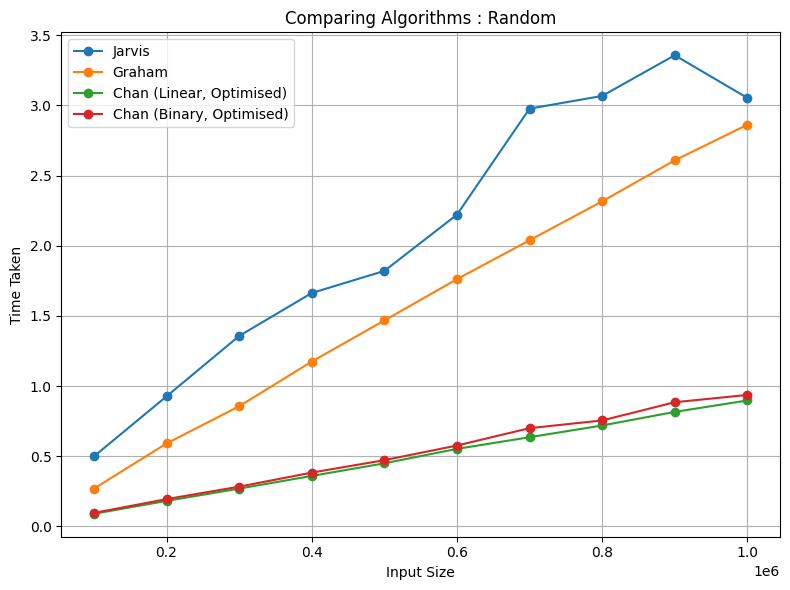

In [454]:
test.compareAlgos(5, [i for i in range(100000, 1100000, 100000)], 0, False)